https://projects.volkamerlab.org/teachopencadd/talktorials/T005_compound_clustering.html

# Compound clustering - Theory

Compound clustering in pharmaceutical research is often based on chemical or structural similarity between compounds to find groups that share properties as well as to design a diverse and representative set for further analysis.

## General procedure:

- Methods are based on clustering data by similarity between neighboring points.
- In cheminformatics, compounds are often encoded as molecular fingerprints and similarity can be described by the Tanimoto similarity (see Talktorial T004).
    - Fingerprints are binary vectors where each bit indicates the presence or absence of a particular substructural fragment within a molecule.
    - Similarity (or distance) matrix: The similarity between each pair of molecules represented by binary fingerprints is most frequently quantified using the Tanimoto coefficient, which measures the number of common features (bits).
    - The value of the Tanimoto coefficient ranges from zero (no similarity) to one (high similarity).

There are a number of clustering algorithms available, with the Jarvis-Patrick clustering being one of the most widely used algorithms in the pharmaceutical context. Jarvis-Patrick clustering algorithm is defined by two parameters K and K(min):
- Calculate the set of nearest neighbors for each molecule.
- Two molecules cluster together if:
    - they are in each others list of nearest neighbors
    - they have at least of their nearest neighbors in common.

The Jarvis-Patrick clustering algorithm is deterministic and able to deal with large sets of molecules in a matter of a few hours. However, a downside lies in the fact that this method tends to produce large heterogeneous clusters (see Butina clustering, referenced above).
More clustering algorithms can also be found in the scikit-learn clustering module.

## Detailed explanation of Butina clustering

Butina clustering (J. Chem. Inf. Model. (1999), 39 (4), 747) was developed to identify smaller but homogeneous clusters, with the prerequisite that (at least) the cluster centroid will be more similar than a given threshold to every other molecule in the cluster.

These are the key steps in this clustering approach (see flowchart below):
1. Data preparation and compound encoding¶
    - To identify chemical similarities, the compounds in the input data (e.g. given as SMILES) will be encoded as molecular fingerprints, e.g., RDK5 fingerprint which is a subgraph-based fingerprint similar to the well known Daylight Fingerprint (which was used in the original publication).
<br>    
2. Tanimoto similarity (or distance) matrix
    - The similarity between two fingerprints is calculated using the Tanimoto coefficient.
    - Matrix with Tanimoto similarities between all possible molecule/fingerprint pairs ( n*n similarity matrix with n = number of molecules, upper triangle matrix used only).
    - Equally, the distances matrix can be calculated (1- similarity).
<br>        
3. Clustering molecules: Centroids and exclusion spheres (Note: Molecules will be clustered together, if they have a maximum distance below a specified cut-off from the cluster centroid (if distance matrix is used) or if they have a minimum similarity above the specified cut-off (if similarity matrix is used).
    - Identification of potential cluster centroids
        - The cluster centroid is the molecule within a given cluster which has the largest number of neighbors.
        - Annotate neighbors: For each molecule count all molecules with a Tanimoto distance below a given threshold.
        - Sort the molecules by their number of neighbors in descending order, so that potential cluster centroids (i.e. the compounds with the largest number of neighbors) are placed at the top of the file.
    - Clustering based on the exclusion spheres
        - Starting with the first molecule (centroid) in the sorted list.
            - All molecules with a Tanimoto index above or equal to the cut-off value used for clustering then become members of that cluster (in case of similarity).
                - Each molecule that has been identified as a member of the given cluster is flagged and removed from further comparisons. Thus, flagged molecules cannot become either another cluster centroid or a member of another cluster. This process is like putting an exclusion sphere around the newly formed cluster.
                - Once the first compound in the list has found all its neighbors, the first available (i.e. not flagged) compound at the top of the list becomes the new cluster centroid.
            - The same process is repeated for all other unflagged molecules down the list.
        - Molecules that have not been flagged by the end of the clustering process become singletons.
            - Note that some molecules assigned as singletons can have neighbors at the given Tanimoto similarity index, but those neighbors have been excluded by a stronger cluster centroid.


In [ ]:
from IPython.display import IFrame
IFrame("butina_full.pdf", width=800, height=500)

## Picking diverse compounds
Finding representative sets of compounds is a concept often used in pharmaceutical industry.

- Let’s say, we applied a virtual screening campaign but only have a limited amount of resources to experimentally test a few compounds in a confirmatory assay.

- In order to obtain as much information as possible from this screen, we want to select a diverse set. Thus, we pick one representative of each chemical series in our list of potentially active compounds.

Another scenario would be to select one series to gain information about the structure-activity relationship; i.e., how small structural changes in the molecule affect the in vitro activity.

## rdkit.ML.Cluster.Butina module

rdkit.ML.Cluster.Butina.ClusterData(data, nPts, distThresh, isDistData=False, distFunc=<function EuclideanDist>, reordering=False): clusters the data points passed in and returns the list of clusters
    
- data: a list of items with the input data (see discussion of _isDistData_ argument for the exception)
- distThresh: elements within this range of each other are considered to be neighbors
   
Returns:

a tuple of tuples containing information about the clusters:
( (cluster1_elem1, cluster1_elem2, …),
(cluster2_elem1, cluster2_elem2, …), …) The first element for each cluster is its centroid.   


# Practical

(https://www.macinchem.org/reviews/clustering/clustering.php)

## Load data and calculate fingerprints

In [69]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import rdFingerprintGenerator

In [28]:
# Define clustering setup
# input is file with fingerprints
def ClusterFps(fps,cutoff=0.2):
    from rdkit import DataStructs
    from rdkit.ML.Cluster import Butina

    # first generate the distance matrix:
    dists = []
    nfps = len(fps)
    for i in range(1,nfps):
        sims = DataStructs.BulkTanimotoSimilarity(fps[i],fps[:i])
        dists.extend([1-x for x in sims])

    # now cluster the data:
    cs = Butina.ClusterData(dists,nfps,cutoff,isDistData=True)
    return cs

In [34]:
# Next Import molecules and generate fingerprints into a list
# ms = [x for x in Chem.SDMolSupplier('ApprovedDrugs.sdf',removeHs=False)]
# fps = [AllChem.GetMorganFingerprintAsBitVect(x,2,1024) for x in ms]

df = pd.read_csv('P450_2d6_binary.csv')
df.dropna(inplace=True)
print("Dataframe shape:", df.shape)
df.head()

Dataframe shape: (13896, 4)


,Pubchem_SID,Pubchem_CID,SMILES,Activity_Outcome
0,842618,644890.0,CC(C)(C)N1C(=NN=N1)C(C2=CC=CC=C2OC)N3CCN(CC3)C...,Active
1,842953,6602688.0,C1COCCN1CCN2C3=CC=CC=C3N(C2=N)CC(=O)C4=CC(=C(C...,Active
2,843526,645818.0,COC1=CC=CC2=C1NC=C(C2=O)C(=O)NCC3=CC=CS3,Active
3,843662,645965.0,CC1CC2=CC=CC=C2N1C(=O)CN3CCC(CC3)N4C5=C(C=C(C=...,Active
4,844085,646395.0,CCSC1=C(C2(CCCCC2)C(=C(N1)N)C#N)C#N,Active


In [41]:
mol_list = [Chem.MolFromSmiles(smiles) for smiles in df.SMILES.tolist()]
fps = [AllChem.GetMorganFingerprintAsBitVect(x,2,1024) for x in mol_list]

In [54]:
import time
start = time.time() 
clusters=ClusterFps(fps,cutoff=0.7)
end = time.time()
print(f'This clustering session took {(end - start) / 60} minutes.')

This clustering session took 0.9683501839637756 minutes.


In [55]:
# Give a short report about the numbers of clusters and their sizes
num_clust_g1 = sum(1 for c in clusters if len(c) == 1)
num_clust_g5 = sum(1 for c in clusters if len(c) > 5)
num_clust_g25 = sum(1 for c in clusters if len(c) > 25)
num_clust_g50 = sum(1 for c in clusters if len(c) > 50)

print("total # clusters: ", len(clusters))
print("# clusters with only 1 compound: ", num_clust_g1)
print("# clusters with >5 compounds: ", num_clust_g5)
print("# clusters with >25 compounds: ", num_clust_g25)
print("# clusters with >50 compounds: ", num_clust_g50)

total # clusters:  2103
# clusters with only 1 compound:  960
# clusters with >5 compounds:  413
# clusters with >25 compounds:  88
# clusters with >50 compounds:  41


|cutoff|total cmpds|total clusters|cluster 1|cluster >5|cluster >25|cluster >50|
|------|:------:|:------:|:------:|:------:|:------:|:------:|
|0.3|13896|10386|8768|153|4|1|
|0.4|13896|8801|6936|211|18|3|
|0.5|13896|6986|4949|295|33|12|
|0.6|13896|4570|2687|450|52|17|
|0.7|13896|2103|960|413|88|41|

<BarContainer object of 2103 artists>

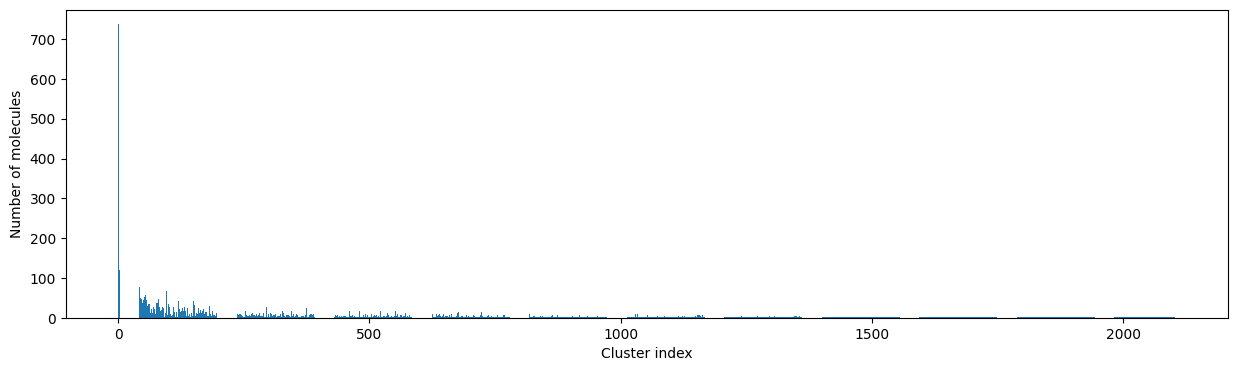

In [56]:
# Plot the size of the clusters
fig, ax = plt.subplots(figsize=(15, 4))
ax.set_xlabel("Cluster index")
ax.set_ylabel("Number of molecules")
ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=5)

How to pick a reasonable cutoff?

Since the clustering result depends on the threshold chosen by the user, we will have a closer look on the choice of a cutoff.

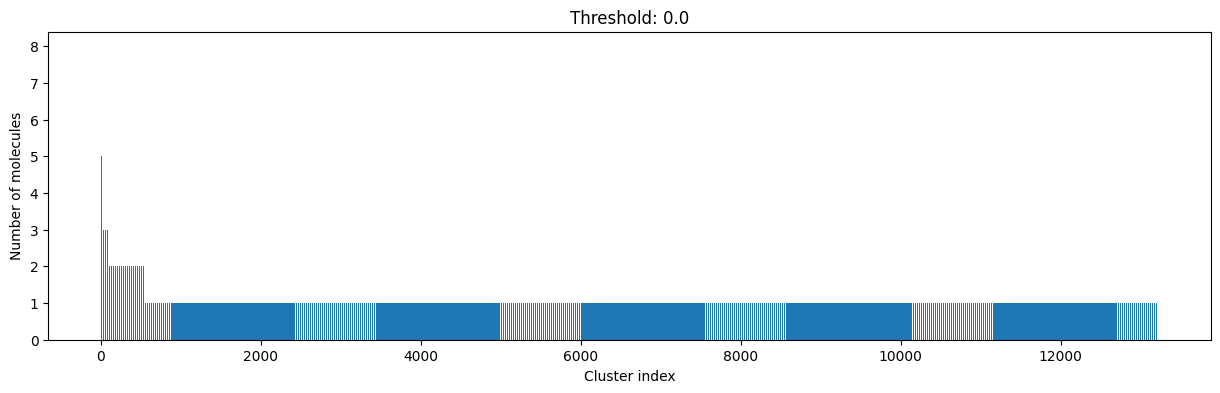

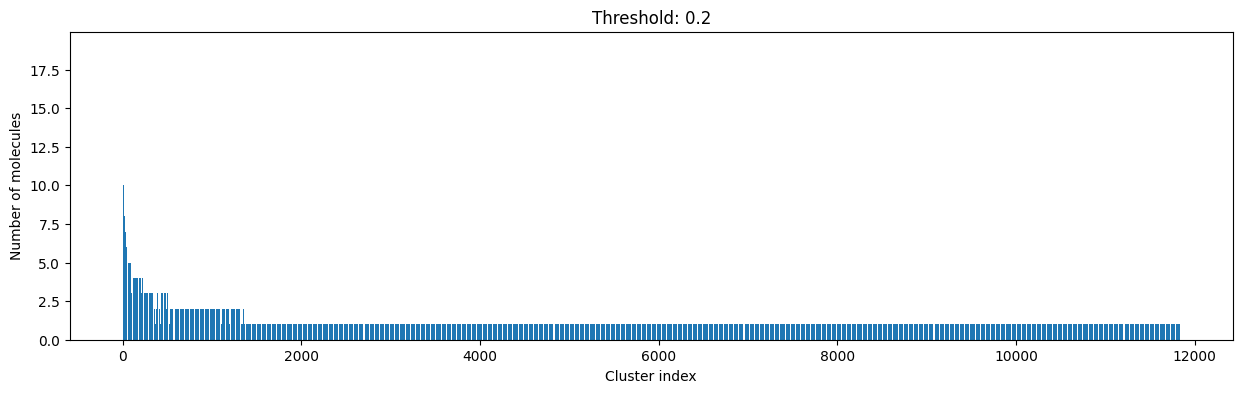

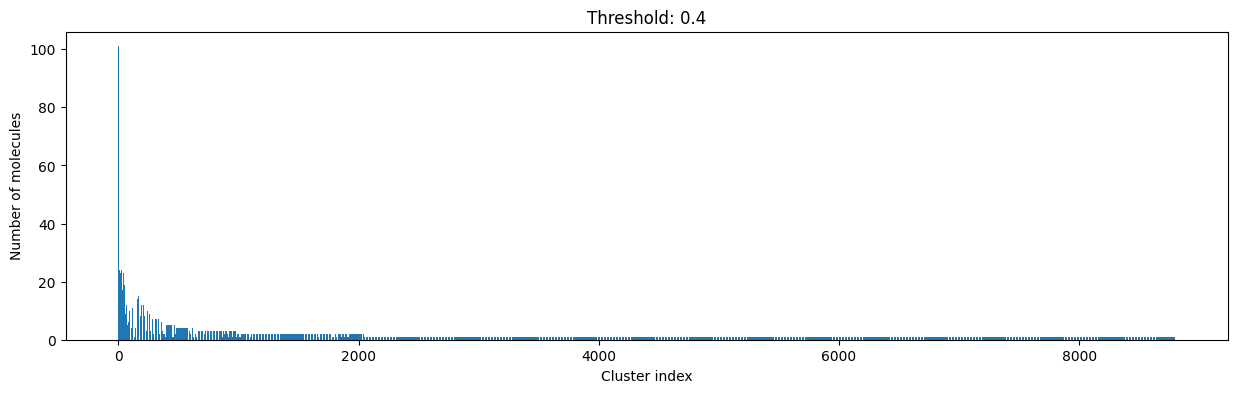

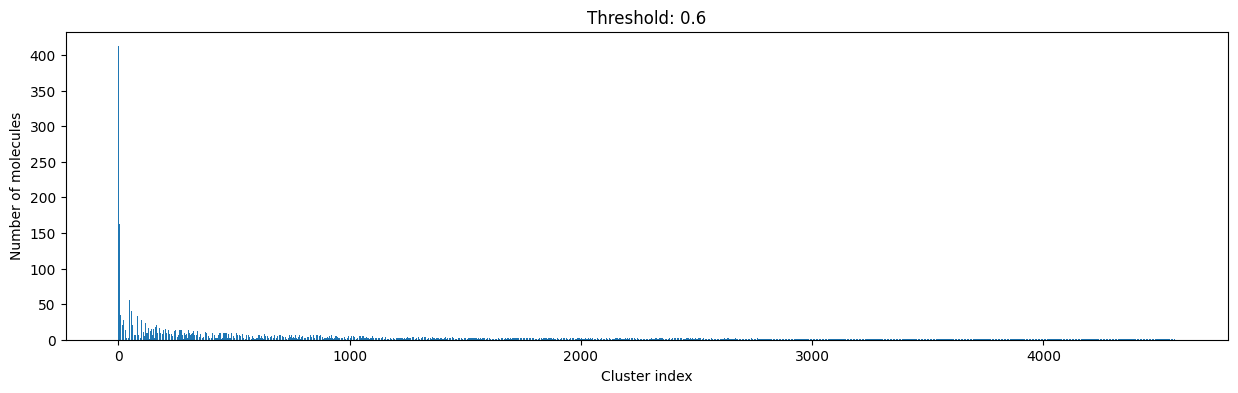

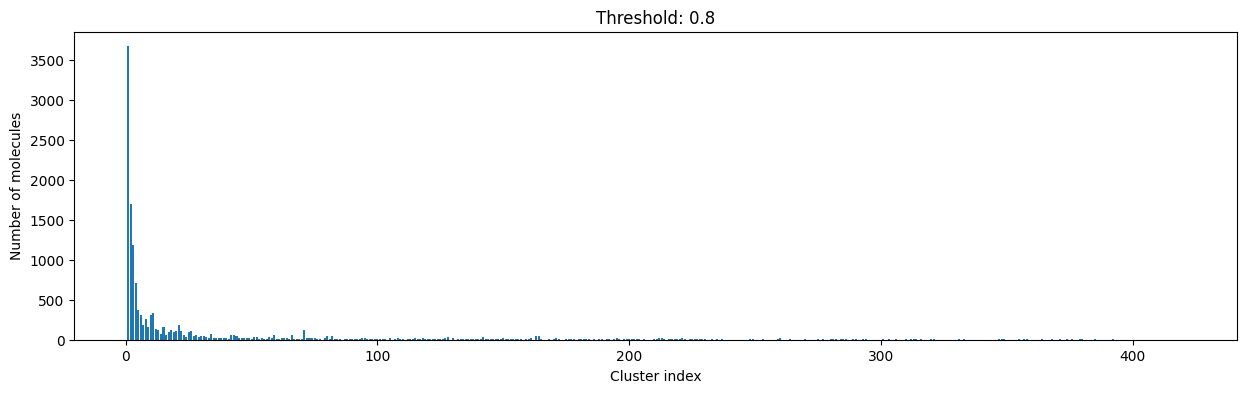

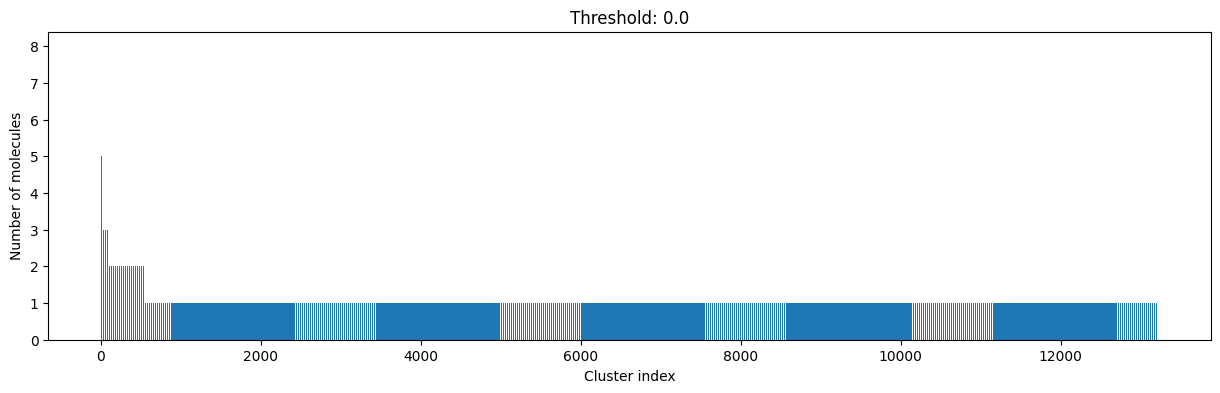

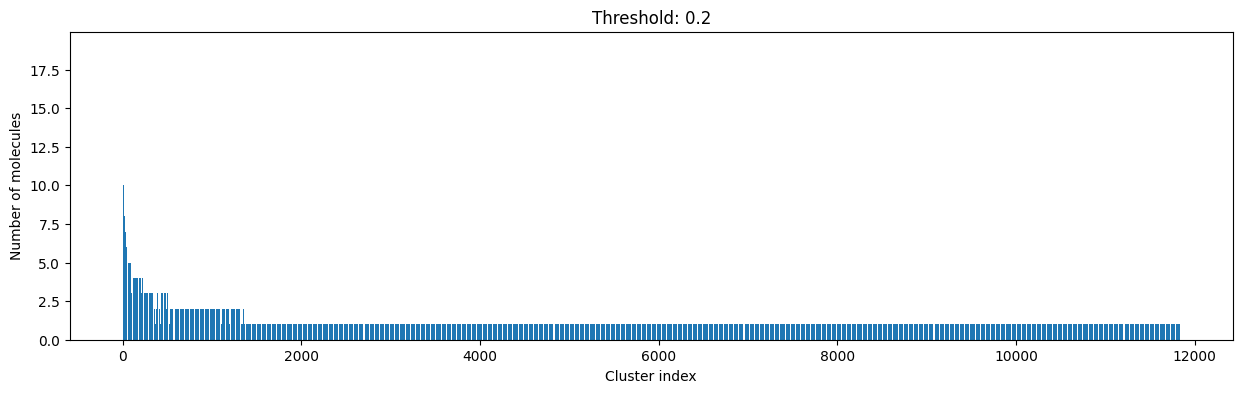

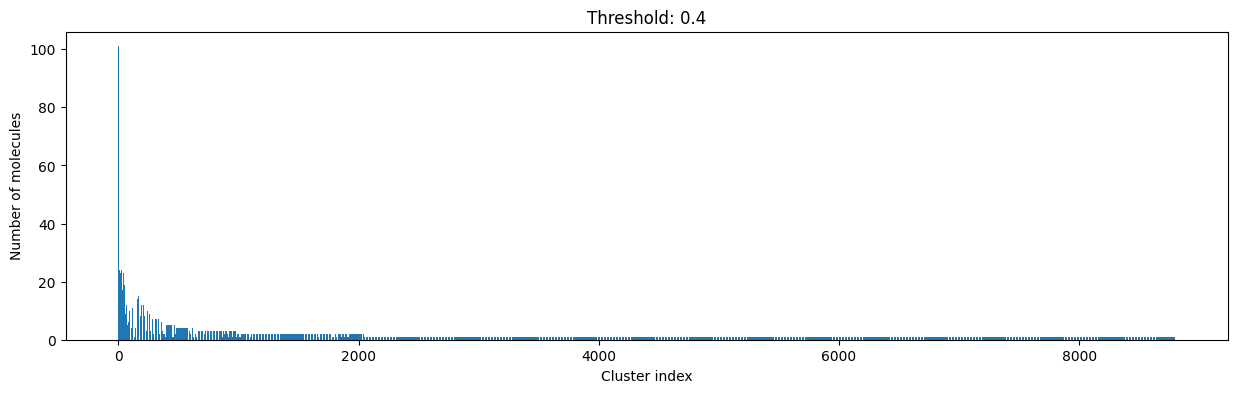

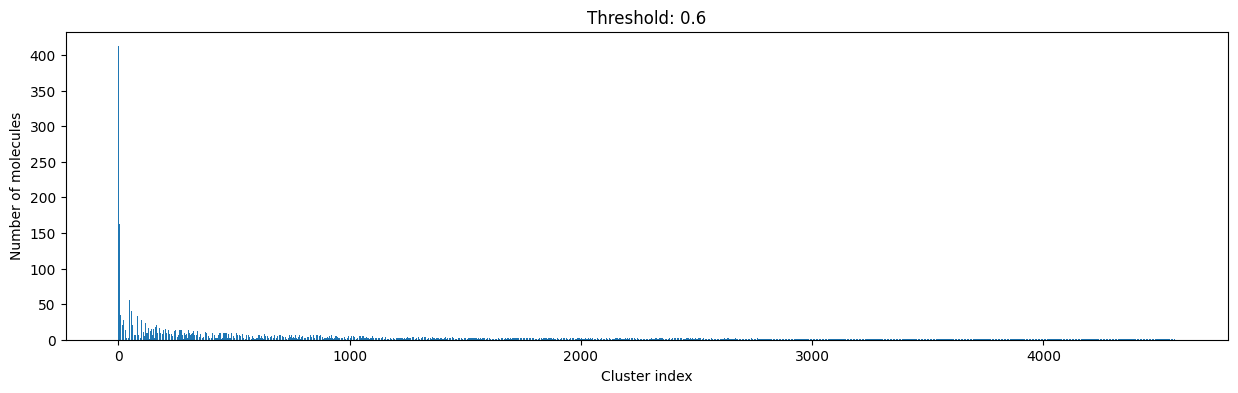

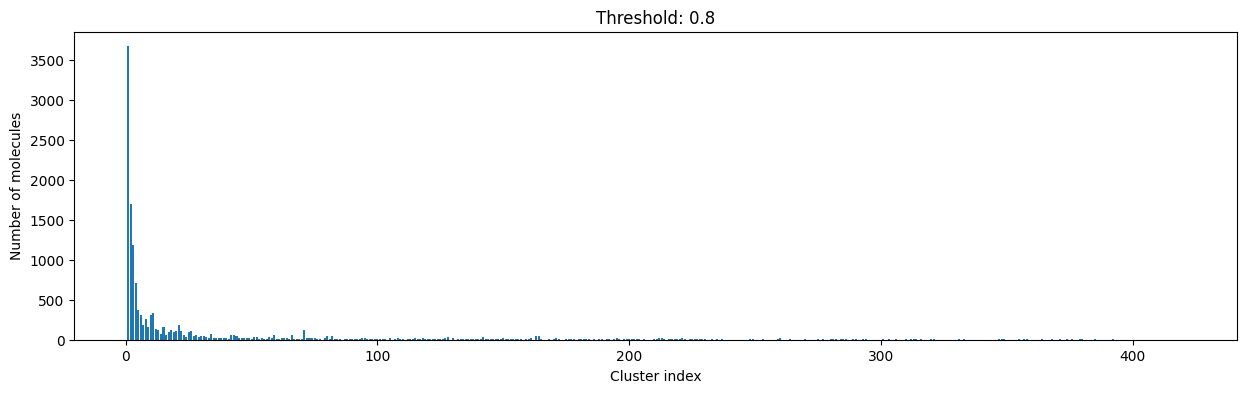

In [58]:
for cutoff in numpy.arange(0.0, 1.0, 0.2):
    clusters = ClusterFps(fps,cutoff=cutoff)
    fig, ax = plt.subplots(figsize=(15, 4))
    ax.set_title(f"Threshold: {cutoff:3.1f}")
    ax.set_xlabel("Cluster index")
    ax.set_ylabel("Number of molecules")
    ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=5)
    display(fig)

## As you can see, the higher the threshold (distance cutoff), the more molecules are considered as similar and, therefore, clustered into less clusters. The lower the threshold, the more small clusters and “singletons” appear.

Number of clusters: 2103 from 13896 molecules at distance cut-off 0.70
Number of molecules in largest cluster: 737


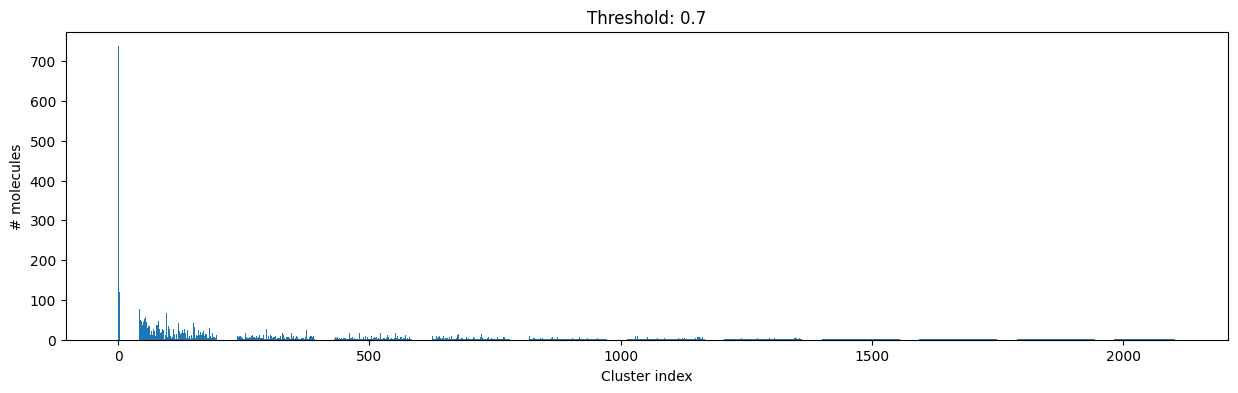

In [62]:
cutoff = 0.7
clusters = ClusterFps(fps,cutoff=cutoff)

# Plot the size of the clusters - save plot
fig, ax = plt.subplots(figsize=(15, 4))
ax.set_xlabel("Cluster index")
ax.set_ylabel("# molecules")
ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters])
ax.set_title(f"Threshold: {cutoff:3.1f}")
fig.savefig(
    f"cluster_dist_cutoff_{cutoff:4.2f}.png",
    dpi=300,
    bbox_inches="tight",
    transparent=True,
)

print(f"Number of clusters: {len(clusters)} from {len(mol_list)} molecules at distance cut-off {cutoff:.2f}")
print("Number of molecules in largest cluster:", len(clusters[0]))

### Visualizing the clusters

10 examples from largest cluster<br>
Now, let’s have a closer look at the first 10 molecular structures of the first/largest clusters.

Ten molecules from largest cluster:


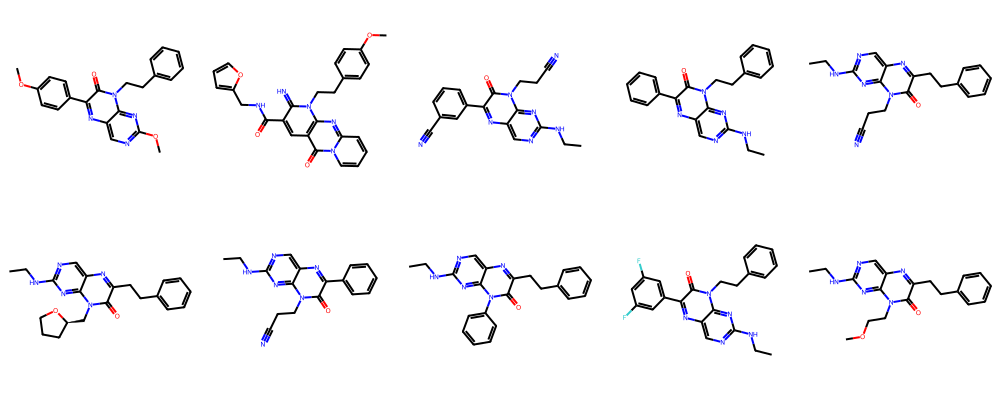

In [66]:
print("Ten molecules from largest cluster:")
# Draw molecules
Draw.MolsToGridImage(
    [mol_list[i] for i in clusters[0][:10]],
    #legends=[mol_list[i][1] for i in clusters[0][:10]],
    molsPerRow=5,
)

# Picking the final list of compounds

In the following, we are going to pick a final list of max. 3000 compounds as a diverse subset.

For this, we take the cluster centroid from each cluster (i.e. the first molecule of each cluster) and then for each cluster (starting with the largest one) we take the 10 molecules (or 50% if less than 10 molecules are left in the cluster) that are most similar to the centroid, until we have selected max. 1000 compounds. Thus, we have representatives of each cluster.

Aim of this compound picking is to ensure the diversity for a smaller set of compounds which are proposed for testing in a confirmatory assay.

Picking procedure was adapted from TDT tutorial notebook by S. Riniker and G. Landrum.

As described there: the idea behind this approach is to ensure diversity (representatives of each cluster) while getting some SAR (structure-activity relationship) from the results of the confirmatory assay (groups of quite similar molecules from larger clusters retained).

In [67]:
# Get cluster centers.
# Get the cluster center of each cluster (first molecule in each cluster)
cluster_centers = [mol_list[c[0]] for c in clusters]
# How many cluster centers/clusters do we have?
print("Number of cluster centers:", len(cluster_centers))
# NBVAL_CHECK_OUTPUT

Number of cluster centers: 2103


In [71]:
# Sort the molecules within a cluster based on their similarity
# to the cluster center and sort the clusters based on their size

rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
sorted_clusters = []
for cluster in clusters:
    if len(cluster) <= 1:
        continue  # Singletons
    # else:
    # Compute fingerprints for each cluster element
    sorted_fingerprints = [rdkit_gen.GetFingerprint(mol_list[i]) for i in cluster]
    # Similarity of all cluster members to the cluster center
    similarities = DataStructs.BulkTanimotoSimilarity(
        sorted_fingerprints[0], sorted_fingerprints[1:]
    )
    # Add index of the molecule to its similarity (centroid excluded!)
    similarities = list(zip(similarities, cluster[1:]))
    # Sort in descending order by similarity
    similarities.sort(reverse=True)
    # Save cluster size and index of molecules in clusters_sort
    sorted_clusters.append((len(similarities), [i for _, i in similarities]))
    # Sort in descending order by cluster size
    sorted_clusters.sort(reverse=True)


## Pick a maximum of 3000 compounds.

In [74]:
# Count selected molecules, pick cluster centers first
selected_molecules = cluster_centers.copy()
# Take 10 molecules (or a maximum of 50%) of each cluster starting with the largest one
index = 0
pending = 3000 - len(selected_molecules)
while pending > 0 and index < len(sorted_clusters):
    # Take indices of sorted clusters
    tmp_cluster = sorted_clusters[index][1]
    # If the first cluster is > 10 big then take exactly 10 compounds
    if sorted_clusters[index][0] > 10:
        num_compounds = 10
    # If smaller, take half of the molecules
    else:
        num_compounds = int(0.5 * len(tmp_cluster)) + 1
    if num_compounds > pending:
        num_compounds = pending
    # Write picked molecules and their structures into list of lists called picked_fps
    selected_molecules += [mol_list[i] for i in tmp_cluster[:num_compounds]]
    index += 1
    pending = 3000 - len(selected_molecules)
print("# Selected molecules:", len(selected_molecules))

# Selected molecules: 3000


# Next try my 300,000 cmpd library

In [91]:
df_sc196 = pd.read_csv('SC196Simplified.csv')
df_sc196.drop(columns='Unnamed: 3',axis=1, inplace=True)
print("Dataframe shape:", df_sc196.shape)
df_sc196.head()

Dataframe shape: (304043, 3)


,SMILE,BARCODE,Activity
0,CC1=CC=C(O1)C1(C)NN=C(S1)C1=CC=CC=C1O,SW124420-1,-23.122
1,NC1=CC2=C(C=C1)C1=C(SS2)C=C(N)C=C1,SW103404-1,-22.934
2,CCCCN1C(NC(=S)NC2=CC=CC=C2)=NC2=C1C=CC=C2,SW172548-1,-24.275
3,CC1=CC=C(C=C1)C1=NC2=C(C=CC=C2)C(NN=CC2=CC=NC=...,SW151816-1,-26.652
4,CC1=CC=C(O)C(=C1)N1SC2=C(C1=S)C1=CC(C)=CC=C1NC...,SW162310-1,-20.033


In [92]:
df_sc196.isna().sum()

SMILE       0
BARCODE     0
Activity    0
dtype: int64

In [94]:
start = time.time()
sc196_mol = [Chem.MolFromSmiles(smiles) for smiles in df_sc196.SMILE.tolist()]
end = time.time()
print(f'Molecule list generation took {(end - start) / 60} minutes.')

[23:37:06] Explicit valence for atom # 6 O, 3, is greater than permitted
[23:37:06] Explicit valence for atom # 6 O, 3, is greater than permitted
[23:37:14] Explicit valence for atom # 18 N, 4, is greater than permitted
[23:37:17] Explicit valence for atom # 12 S, 8, is greater than permitted
[23:37:23] Explicit valence for atom # 17 S, 8, is greater than permitted
[23:37:24] Explicit valence for atom # 17 S, 8, is greater than permitted
[23:37:33] Explicit valence for atom # 8 O, 3, is greater than permitted
[23:37:35] Explicit valence for atom # 8 O, 3, is greater than permitted
[23:38:04] Explicit valence for atom # 27 N, 4, is greater than permitted
[23:38:06] WARNING: not removing hydrogen atom without neighbors


Molecule list generation took 1.126494034131368 minutes.


In [104]:
sc196_mol.count(None)

9

In [106]:
sc196_mol = [i for i in sc196_mol if i is not None]
sc196_mol.count(None), len(sc196_mol)

(0, 304034)

In [107]:
start = time.time()
fps_sc196 = [AllChem.GetMorganFingerprintAsBitVect(x,2,1024) for x in sc196_mol]
end = time.time()
print(f'Fingerprint generation took {(end - start) / 60} minutes.')

Fingerprint generation took 0.5858638127644856 minutes.


In [ ]:
start = time.time() 
clusters_sc196=ClusterFps(fps_sc196,cutoff=0.8)
end = time.time()
print(f'This clustering session took {(end - start) / 60} minutes.')